# Augmentation

In [ ]:
# Augmentation
import os
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
# Set the path to your dataset folder in Google Drive
base_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Check this path is correct

# Define the folders for each class
class_folders = {
    'acne': 'acne',
    'hyperpigmentation': 'hyperpigmentation',
    'Nail_psoriasis': 'Nail_psoriasis',
    'SJS-TEN': 'SJS-TEN',
    'Vitiligo': 'Vitiligo' # <-- Double-check this name matches your folder exactly
}

# The target number of images per class
target_image_count = 2000

# --- Augmentation Setup ---
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Main Loop ---
for class_name, folder_name in class_folders.items():
    folder_path = os.path.join(base_dataset_path, folder_name)

    # --- ⭐️ ERROR FIX: Check if the folder exists ---
    if not os.path.isdir(folder_path):
        print(f"🚨 ERROR: Directory not found for class '{class_name}': {folder_path}. Skipping.")
        continue

    # Get the list of all images in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(images)

    print(f"\nProcessing '{class_name}': Found {num_images} images.")

    # --- Logic to Increase, Decrease, or Skip ---
    if num_images < target_image_count:
        # --- AUGMENTATION (INCREASE) LOGIC ---
        num_to_generate = target_image_count - num_images
        print(f"Augmenting '{class_name}': Generating {num_to_generate} new images...")

        # Select random images from the folder to augment
        images_to_augment = random.choices(images, k=num_to_generate)

        for image_name in images_to_augment:
            image_path = os.path.join(folder_path, image_name)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))
                x = np.array(img)
                x = x.reshape((1,) + x.shape)

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    augmented_image = Image.fromarray(batch[0].astype('uint8'))
                    new_image_name = f"aug_{random.randint(10000, 99999)}_{image_name}"
                    augmented_image.save(os.path.join(folder_path, new_image_name))
                    break # Stop after one is generated
            except Exception as e:
                print(f"Could not process image {image_name}. Error: {e}")

    elif num_images > target_image_count:
        # --- ⭐️ NEW: DECREASE LOGIC ---
        num_to_delete = num_images - target_image_count
        print(f"Decreasing '{class_name}': Randomly deleting {num_to_delete} images...")

        # Randomly select images to delete
        images_to_delete = random.sample(images, num_to_delete)

        for image_name in images_to_delete:
            file_to_delete_path = os.path.join(folder_path, image_name)
            try:
                os.remove(file_to_delete_path)
            except Exception as e:
                print(f"Could not delete image {image_name}. Error: {e}")

    else: # num_images == target_image_count
        print(f"'{class_name}' already has {target_image_count} images. No action needed.")


print("\nProcessing complete! ✅")



Processing 'acne': Found 1148 images.
Augmenting 'acne': Generating 852 new images...

Processing 'hyperpigmentation': Found 2000 images.
'hyperpigmentation' already has 2000 images. No action needed.

Processing 'Nail_psoriasis': Found 2000 images.
'Nail_psoriasis' already has 2000 images. No action needed.

Processing 'SJS-TEN': Found 2000 images.
'SJS-TEN' already has 2000 images. No action needed.

Processing 'Vitiligo': Found 2000 images.
'Vitiligo' already has 2000 images. No action needed.

Processing complete! ✅


# Split Dataset

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# Path to your balanced dataset (where each class has 2000 images)
source_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Path to your processed dataset

# Path where the new split dataset will be created
output_dataset_path = '/content/drive/MyDrive/Thesis/Split_Dataset'

# Define the split ratios
# 70% for training, 15% for validation, 15% for testing
split_ratios = (0.7, 0.15, 0.15)

# --- Main Splitting Logic ---
print("Starting dataset split...")

# Create the main output directories (train, validation, test)
if os.path.exists(output_dataset_path):
    shutil.rmtree(output_dataset_path) # Remove old directory to ensure a clean split
    print(f"Removed existing directory at: {output_dataset_path}")

train_dir = os.path.join(output_dataset_path, 'train')
validation_dir = os.path.join(output_dataset_path, 'validation')
test_dir = os.path.join(output_dataset_path, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of class folders from the source directory
class_names = [d for d in os.listdir(source_dataset_path) if os.path.isdir(os.path.join(source_dataset_path, d))]

# Loop through each class folder
for class_name in class_names:
    print(f"\nProcessing class: {class_name}")

    # Create class-specific subdirectories in train, validation, and test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image file names for the current class
    source_class_dir = os.path.join(source_dataset_path, class_name)
    all_files = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]

    # Shuffle the files randomly for an unbiased split
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(total_files * split_ratios[0])
    validation_end = train_end + int(total_files * split_ratios[1])

    # Slice the list of files into the three sets
    train_files = all_files[:train_end]
    validation_files = all_files[train_end:validation_end]
    test_files = all_files[validation_end:]

    # --- Function to copy files ---
    def copy_files(files, source_dir, dest_dir):
        for f in files:
            shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))

    # Copy files to their new destination
    copy_files(train_files, source_class_dir, os.path.join(train_dir, class_name))
    copy_files(validation_files, source_class_dir, os.path.join(validation_dir, class_name))
    copy_files(test_files, source_class_dir, os.path.join(test_dir, class_name))

    print(f"  - Training set:   {len(train_files)} images")
    print(f"  - Validation set: {len(validation_files)} images")
    print(f"  - Testing set:    {len(test_files)} images")

print("\nDataset splitting complete! ✅")

Starting dataset split...
Removed existing directory at: /content/drive/MyDrive/Thesis/Split_Dataset

Processing class: acne
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: hyperpigmentation
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Nail_psoriasis
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Vitiligo
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: SJS-TEN
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Dataset splitting complete! ✅


# Copy Dataset to Localstorage

In [1]:
import os
import shutil
from tqdm import tqdm

# Path to your dataset on Google Drive
drive_dataset_path = "/content/drive/MyDrive/Thesis/Split_Dataset"
# Path where you want to copy locally (Colab's fast storage)
local_dataset_path = "/content/dataset/Split_Dataset"

# Remove any old copy if exists
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# Copy dataset from Drive to Colab local storage
print("Copying dataset from Drive to local storage...")
shutil.copytree(drive_dataset_path, local_dataset_path)

print("✅ Dataset copied to:", local_dataset_path)



Copying dataset from Drive to local storage...
✅ Dataset copied to: /content/dataset/Split_Dataset


# Model Training

## Model Name


Found 5 classes: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne', 'hyperpigmentation']

--- Starting Initial Training (Training Ensemble Head) ---
Epoch 1/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 759s 5s/step - accuracy: 0.6735 - loss: 1.2992 - val_accuracy: 0.9353 - val_loss: 0.2157
Epoch 2/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.9147 - loss: 0.2481 - val_accuracy: 0.9600 - val_loss: 0.1320
Epoch 3/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9397 - loss: 0.1654 - val_accuracy: 0.9493 - val_loss: 0.1236
Epoch 4/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9534 - loss: 0.1269 - val_accuracy: 0.9640 - val_loss: 0.0957
Epoch 5/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.9707 - loss: 0.0844 - val_accuracy: 0.9713 - val_loss: 0.0771
Epoch 6/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.9780 - loss: 0.0729 - val_accuracy: 0.9673 - val_loss: 0.0880
Epoch 7/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9867 -

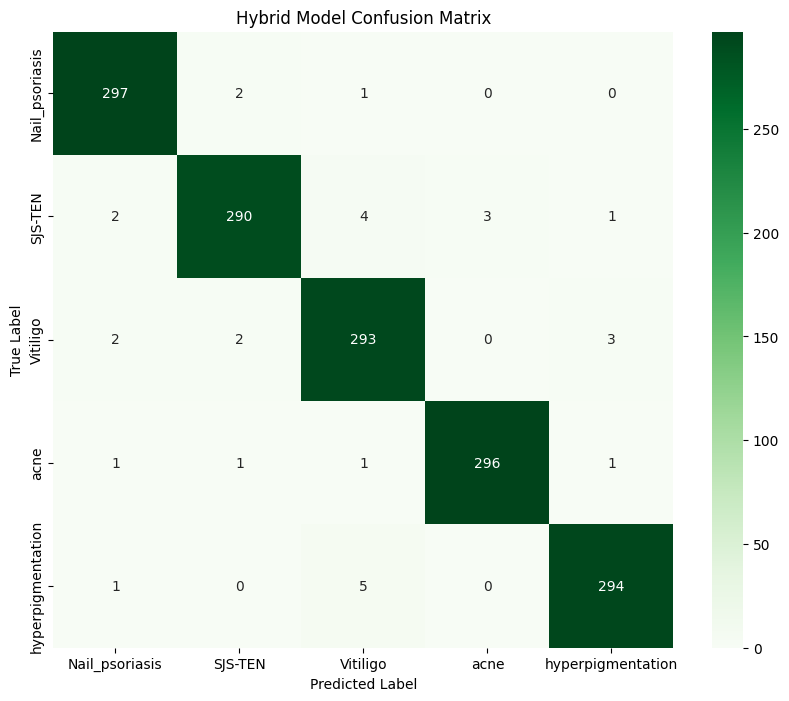

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16, NASNetMobile

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate, Lambda

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import os

import numpy as np

import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import cv2

import glob

# --- 1. SETUP & CONFIGURATION ---

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set paths to your dataset

base_dir = '/content/dataset/Split_Dataset'

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

# Model parameters

IMG_SIZE = 224

BATCH_SIZE = 64

INITIAL_EPOCHS = 8

FINE_TUNE_EPOCHS = 12

TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

class_names = sorted(os.listdir(train_dir))

num_classes = len(class_names)

print(f"Found {num_classes} classes: {class_names}")

# --- 2. HIGH-PERFORMANCE tf.data PIPELINE (CORRECTED) ---

def parse_image(file_path):

    # Create the label from the file path

    parts = tf.strings.split(file_path, os.path.sep)

    label_str = parts[-2]

    label = tf.argmax(tf.cast(class_names == label_str, tf.int32))

    # Load and decode the image

    img = tf.io.read_file(file_path)

    img = tf.image.decode_jpeg(img, channels=3)

    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    return img, label

def create_dataset(directory, is_training=True):

    file_paths = glob.glob(os.path.join(directory, '*/*.*')) # More robust to different extensions

    dataset = tf.data.Dataset.from_tensor_slices(file_paths)

    if is_training:

        dataset = dataset.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)

    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)

    # ⭐️ THE FIX: Removed the extra preprocessing map. The model handles it now.

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_dir, is_training=True)

validation_dataset = create_dataset(validation_dir, is_training=False)

# --- 3. Building the Hybrid Model ---

def create_hybrid_model(num_classes):

    # Define a single input, which will be duplicated and preprocessed

    shared_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='shared_input')

    # VGG16 Branch

    vgg_preprocessor = Lambda(tf.keras.applications.vgg16.preprocess_input, name='vgg_preprocess')

    vgg_branch = vgg_preprocessor(shared_input)

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), name='vgg16')

    vgg_output = vgg_base(vgg_branch)

    vgg_base.trainable = False

    # NASNetMobile Branch

    nasnet_preprocessor = Lambda(tf.keras.applications.nasnet.preprocess_input, name='nasnet_preprocess')

    nasnet_branch = nasnet_preprocessor(shared_input)

    nasnet_base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), name='nasnetmobile')

    nasnet_output = nasnet_base(nasnet_branch)

    nasnet_base.trainable = False

    # Get Outputs

    out_vgg = GlobalAveragePooling2D(name='gap_vgg')(vgg_output)

    out_nasnet = GlobalAveragePooling2D(name='gap_nasnet')(nasnet_output)

    # Ensemble Head

    concat_features = Concatenate(name='concat_features')([out_vgg, out_nasnet])

    ensemble_dense_1 = Dense(512, activation='relu', name='ensemble_dense_1')(concat_features)

    ensemble_dropout_1 = Dropout(0.5, name='ensemble_dropout_1')(ensemble_dense_1)

    final_predictions = Dense(num_classes, activation='softmax', dtype='float32', name='final_predictions')(ensemble_dropout_1)

    model = Model(inputs=shared_input, outputs=final_predictions, name="Hybrid_VGG_NASNet")

    return model, [vgg_base, nasnet_base]

# A separate function to create the model in float32 for stable XAI

def create_hybrid_model_float32(num_classes):

    # This function remains mostly the same, just ensure it uses the float32 model definition

    shared_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='shared_input', dtype=tf.float32)

    vgg_preprocessor = Lambda(tf.keras.applications.vgg16.preprocess_input, name='vgg_preprocess')

    vgg_branch = vgg_preprocessor(shared_input)

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), name='vgg16')

    vgg_output = vgg_base(vgg_branch)

    nasnet_preprocessor = Lambda(tf.keras.applications.nasnet.preprocess_input, name='nasnet_preprocess')

    nasnet_branch = nasnet_preprocessor(shared_input)

    nasnet_base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), name='nasnetmobile')

    nasnet_output = nasnet_base(nasnet_branch)

    out_vgg = GlobalAveragePooling2D(name='gap_vgg')(vgg_output)

    out_nasnet = GlobalAveragePooling2D(name='gap_nasnet')(nasnet_output)

    concat_features = Concatenate(name='concat_features')([out_vgg, out_nasnet])

    ensemble_dense_1 = Dense(512, activation='relu', name='ensemble_dense_1')(concat_features)

    ensemble_dropout_1 = Dropout(0.5, name='ensemble_dropout_1')(ensemble_dense_1)

    final_predictions = Dense(num_classes, activation='softmax', name='final_predictions')(ensemble_dropout_1)

    model = Model(inputs=shared_input, outputs=final_predictions, name="Hybrid_Float32")

    return model

hybrid_model, base_models = create_hybrid_model(num_classes)

# --- 4. Compile and Train ---

optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))

hybrid_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Initial Training (Training Ensemble Head) ---")

history = hybrid_model.fit(train_dataset, epochs=INITIAL_EPOCHS, validation_data=validation_dataset)

# --- 5. Fine-Tuning Phase ---

print("\n--- Starting Fine-Tuning ---")

for base_model in base_models:

    base_model.trainable = True

    if 'vgg16' in base_model.name: fine_tune_at = -4 # Unfreeze last conv block

    else: fine_tune_at = -30 # Unfreeze top blocks of NASNet

    for layer in base_model.layers[:fine_tune_at]:

        layer.trainable = False

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))

hybrid_model.compile(optimizer=optimizer_fine, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = hybrid_model.fit(train_dataset, epochs=TOTAL_EPOCHS, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

# --- 6. Plotting Training History ---

# ... (plotting code will go here, after training is complete)

# --- 7. FINAL EVALUATION ON TEST SET ---

print("\n\n--- Starting Final Evaluation on Test Data ---")

test_dataset = create_dataset(test_dir, is_training=False)

test_loss, test_accuracy = hybrid_model.evaluate(test_dataset)

print(f"\nOverall Test Accuracy: {test_accuracy*100:.2f}%")

y_pred, y_true = [], []

for images, labels in test_dataset:

    # We pass a dict with one key since the model expects a dict

    preds = hybrid_model.predict(images)

    y_pred.extend(np.argmax(preds, axis=1))

    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)

y_true = np.array(y_true)

print("\n## Classification Report ##\n")

print(classification_report(y_true, y_pred, target_names=class_names))

print("\n## Confusion Matrix ##\n")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)

plt.title('Hybrid Model Confusion Matrix')

plt.ylabel('True Label')

plt.xlabel('Predicted Label')

plt.show()

# --- 8. EXPLAINABLE AI (XAI) WITH GRAD-CAM ---

# ... (XAI code will go here, after evaluation is complete)
